<font color="orange">Multilevel Monte Carlo simulation for VIX options in the rough
Bergomi model</font>

Convention is different. The parameter $\eta$ in the paper must be 
replaced with $\eta \sqrt{2H}$.

Let $\Delta = 30$ days. The VIX is defined as 

$$
    \text{VIX}_T = \sqrt{\frac1\Delta \int_{T}^{T+\Delta} \xi_T^u \, du}
$$

where, for all $u \geq T$, the instantaneous forward variance at time $T$ for 
maturity $u$ is given by

$$
    \xi_T^u = \xi_0^u 
    \exp\left\{ \eta Y_T^u - \frac{\eta^2}{2}(u^{2H} - (u-T)^{2H})\right\}
$$

and

$$
    Y_T^u = \sqrt{2H} \int_0^T (u-s)^{H-1/2} \, dW_s.
$$

For $n \in \mathbb{N}^*$ timesteps, 
consider the uniform grid $u_i = T + i \Delta/n$ for $i = 0, 1, \ldots, n$.

We need to compute the covariance matrix of the vector 
$\{Y_T^{u_i}\}_{0 \leq i \leq n}$.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import matplotlib as mpl
import numpy as np
import seaborn as sns
from utils import linear_regression

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
COLORS = ["blue", "green", "red", "orange"]
SEED = 1234

We are interested in the right-point rectangle scheme

$$
    \text{VIX}_T^{2,\mathcal{R}_n}
    = \frac{1}{n} \sum_{i=1}^{n} \xi_T^{u_i}
$$

and the trapezoidal scheme

$$
    \text{VIX}_T^{2,\mathcal{T}_n}
    = \frac{1}{2n} \sum_{i=1}^{n} 
    \left(\xi_T^{u_{i-1}} + \xi_T^{u_i}\right)
$$

Observe that $\{\log \xi_{T}^{u_i}\}_{0 \leq i \leq n}$
forms an $(n+1)$-dimensional Gaussian vector with mean vector 
$\mu = \{\mu_i\}_{0 \leq i \leq n}$ and covariance matrix 
$C = \{C_{i,j}\}_{0 \leq i,j \leq n}$ defined as

$$
    \mu_i = \log \xi_0^{u_i} - \frac{\eta^2}{2} (u_i^{2H} - (u_i-T)^{2H})
$$

and 

$$
    C_{i,j} = 2 H \int_0^T (u_i-s)^{H-1/2} (u_j-s)^{H-1/2} \, ds
$$

The covariance matrix term $C_{i,j}$ can be computed in closed form using the 
Gaussian hypergeometric function.

A Monte Carlo estimator for the price of a VIX option with payoff $\varphi$ is

$$
    \mathbb{E}[\varphi(\text{VIX}_T^{2})] 
    \approx \frac{1}{M} \sum_{m=1}^{M} 
    \varphi \left(\frac{1}{n} \sum_{i=1}^{n} \exp\{X_T^{u_i,m}\}\right)
$$

where $X_T^u = \log \xi_T^u$ and $\{\{X_T^{u_i,m}\}_{0 \leq i \leq n}\}_{1 \leq m \leq M}$ are 
i.i.d. samples.

A natural control variate is the lognormal random variable
$\exp\left\{\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i} \right\}$. Observe that
$\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i}$ is normal with mean and standard deviation

$$
    \bar{\mu}_n = \frac{1}{n} \sum_{i=1}^{n} \mu_i,
    \qquad
    \bar{\sigma}_n = \sqrt{\frac{1}{n^2} \sum_{i,j=1}^{n} C_{i,j}}
$$


In [4]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.3**2,
    "rho": -0.7,
    "H": 0.4,
}
params["eta"] = 0.4 * np.sqrt(2.0 * params["H"])

rbergomi = RoughBergomi(**params)

# $L^2$ error for the strong error

In [5]:
T = 3.0 / 12.0
n_mc = 1 * 10**5
n_disc_ref = 2000

In [6]:
# Simulate xi_{T}^{u_i}, shape is (n_disc+1, n_mc)
xi = rbergomi.simulate_vix(T=T, n_mc=n_mc, n_disc=n_disc_ref, seed=SEED, return_xi=True)

In [7]:
xi = np.asarray(xi)

In [8]:
vix2_right_ref = np.mean(np.exp(xi[1:, :]), axis=0)
vix2_trap_ref = 0.5 * np.mean(np.exp(xi[:-1, :]) + np.exp(xi[1:, :]), axis=0)

In [9]:
tab_n_disc = [25, 40, 50, 80, 100, 125, 200, 250]
vix2_right = np.zeros((len(tab_n_disc), n_mc))
vix2_trap = np.zeros_like(vix2_right)

for i in range(len(tab_n_disc)):
    idx = np.arange(start=0, stop=n_disc_ref, step=n_disc_ref // tab_n_disc[i])
    vix2_right[i, :] = np.mean(np.exp(xi[1:, :][idx, :]), axis=0)
    vix2_trap[i, :] = 0.5 * np.mean(
        np.exp(xi[:-1, :][idx, :]) + np.exp(xi[1:, :][idx, :]), axis=0
    )

In [10]:
strong_error_right = np.mean((vix2_right_ref - vix2_right) ** 2, axis=1) ** 0.5
strong_error_trap = np.mean((vix2_trap_ref - vix2_trap) ** 2, axis=1) ** 0.5

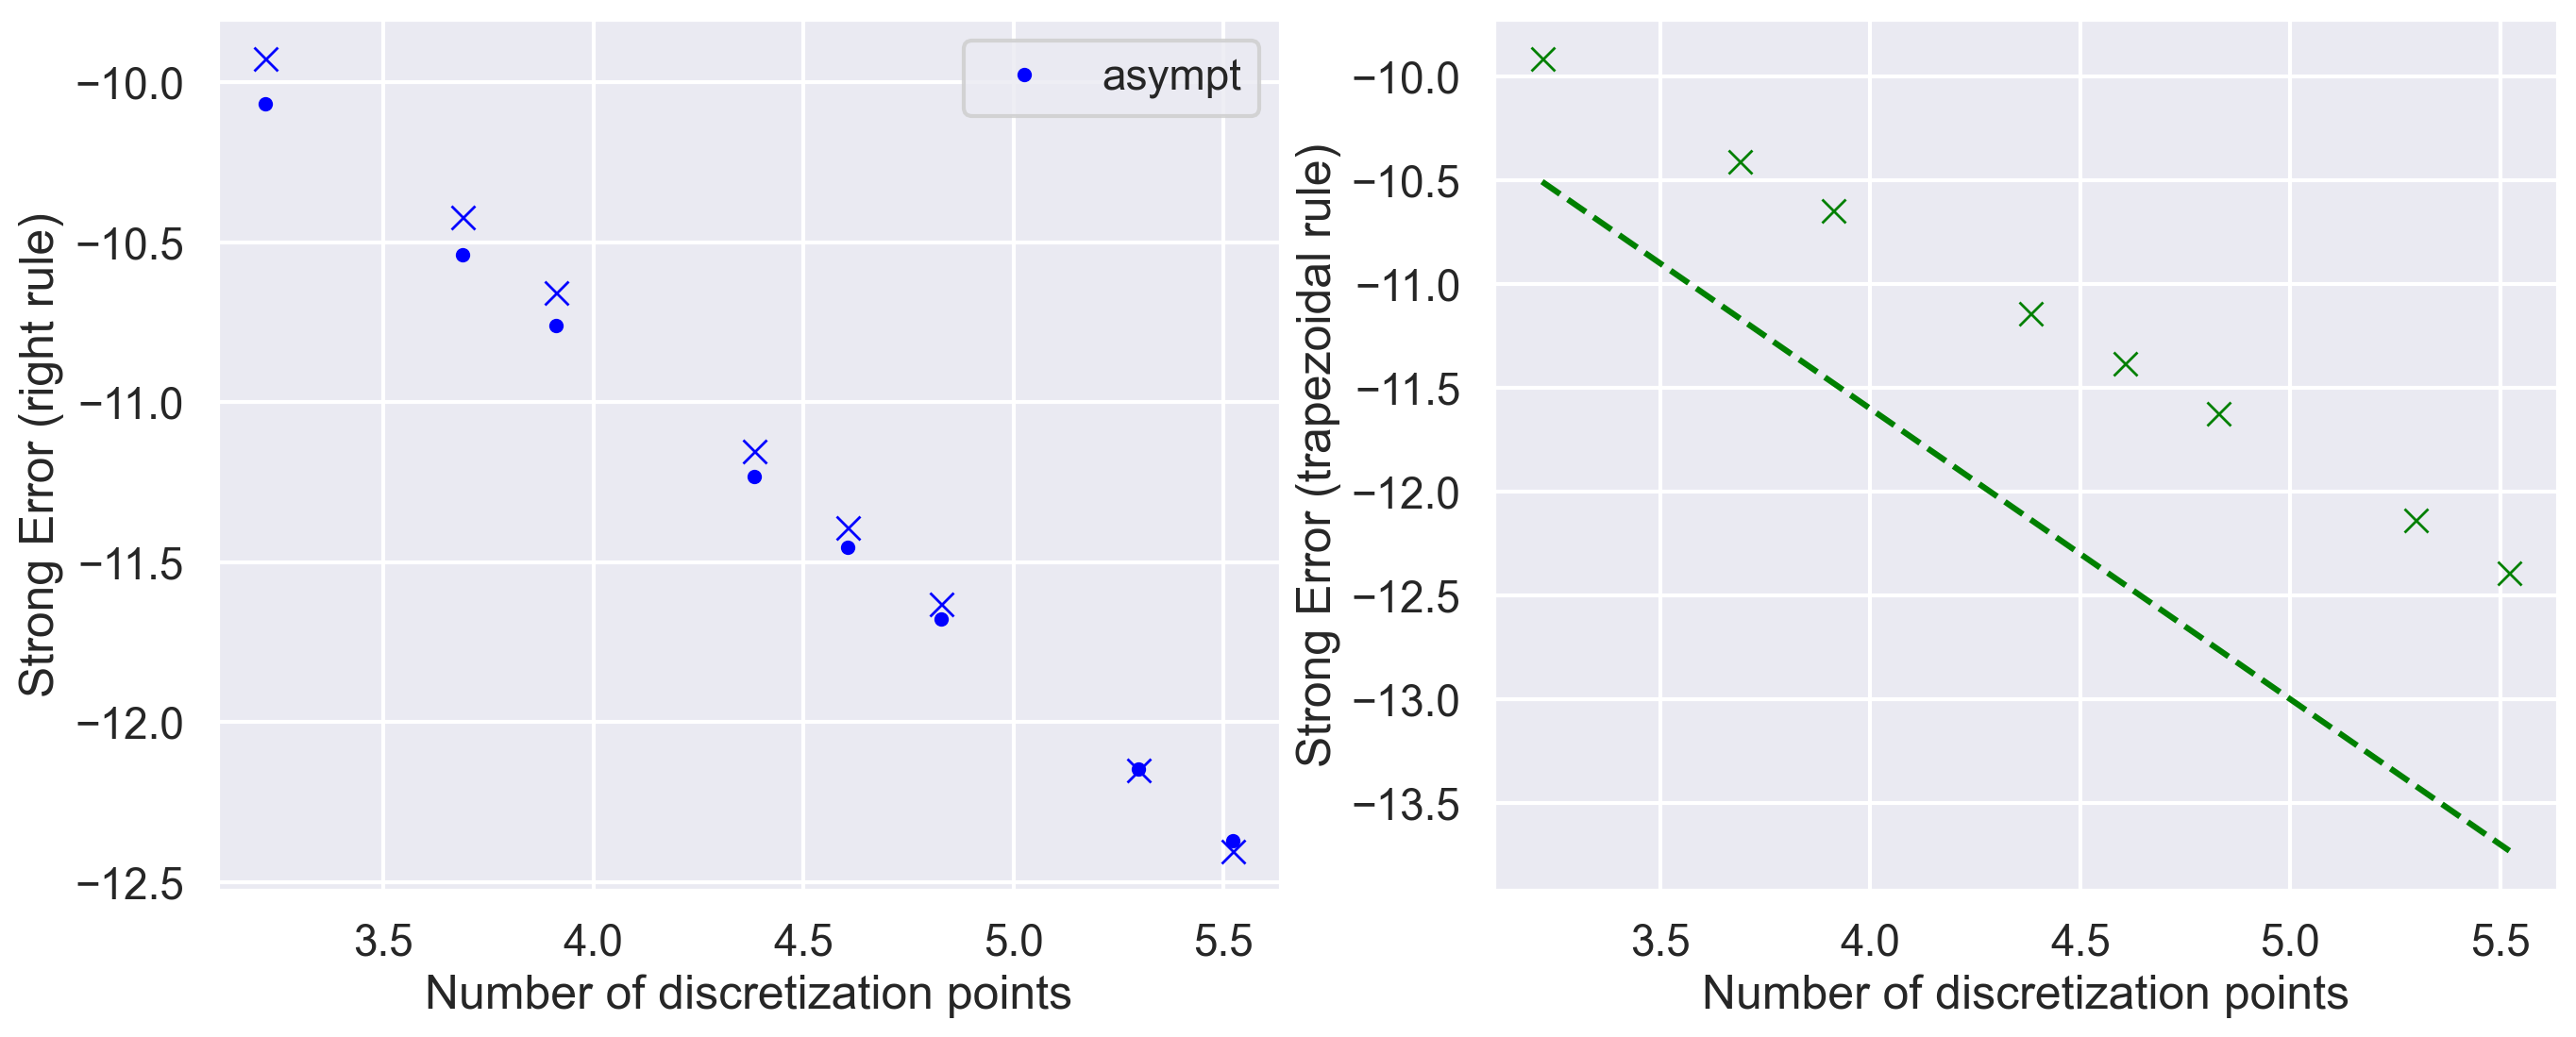

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(strong_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    np.log(rbergomi.limit_strong_error_vix_right(n=tab_n_disc, T=T)),
    ".",
    color=COLORS[0],
    label="asympt",
)
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Strong Error (right rule)")
ax[0].legend()
ax[1].plot(
    np.log(tab_n_disc),
    np.log(strong_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 6,
    "--",
    color=COLORS[1],
)
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Strong Error (trapezoidal rule)")
plt.show()

# Weak error

In [12]:
call_atm_right_ref = np.maximum(
    vix2_right_ref**0.5 - np.mean(vix2_right_ref**0.5), 0.0
).mean()
call_atm_trap_ref = np.maximum(
    vix2_trap_ref**0.5 - np.mean(vix2_trap_ref**0.5), 0.0
).mean()

In [13]:
call_atm_right = np.zeros(len(tab_n_disc))
call_atm_trap = np.zeros_like(call_atm_right)

for i in range(len(tab_n_disc)):
    call_atm_right[i] = np.maximum(
        vix2_right[i, :] ** 0.5 - np.mean(vix2_right[i, :] ** 0.5), 0.0
    ).mean()
    call_atm_trap[i] = np.maximum(
        vix2_trap[i, :] ** 0.5 - np.mean(vix2_trap[i, :] ** 0.5), 0.0
    ).mean()

In [14]:
weak_error_right = np.abs(call_atm_right_ref - call_atm_right)
weak_error_trap = np.abs(call_atm_trap_ref - call_atm_trap)

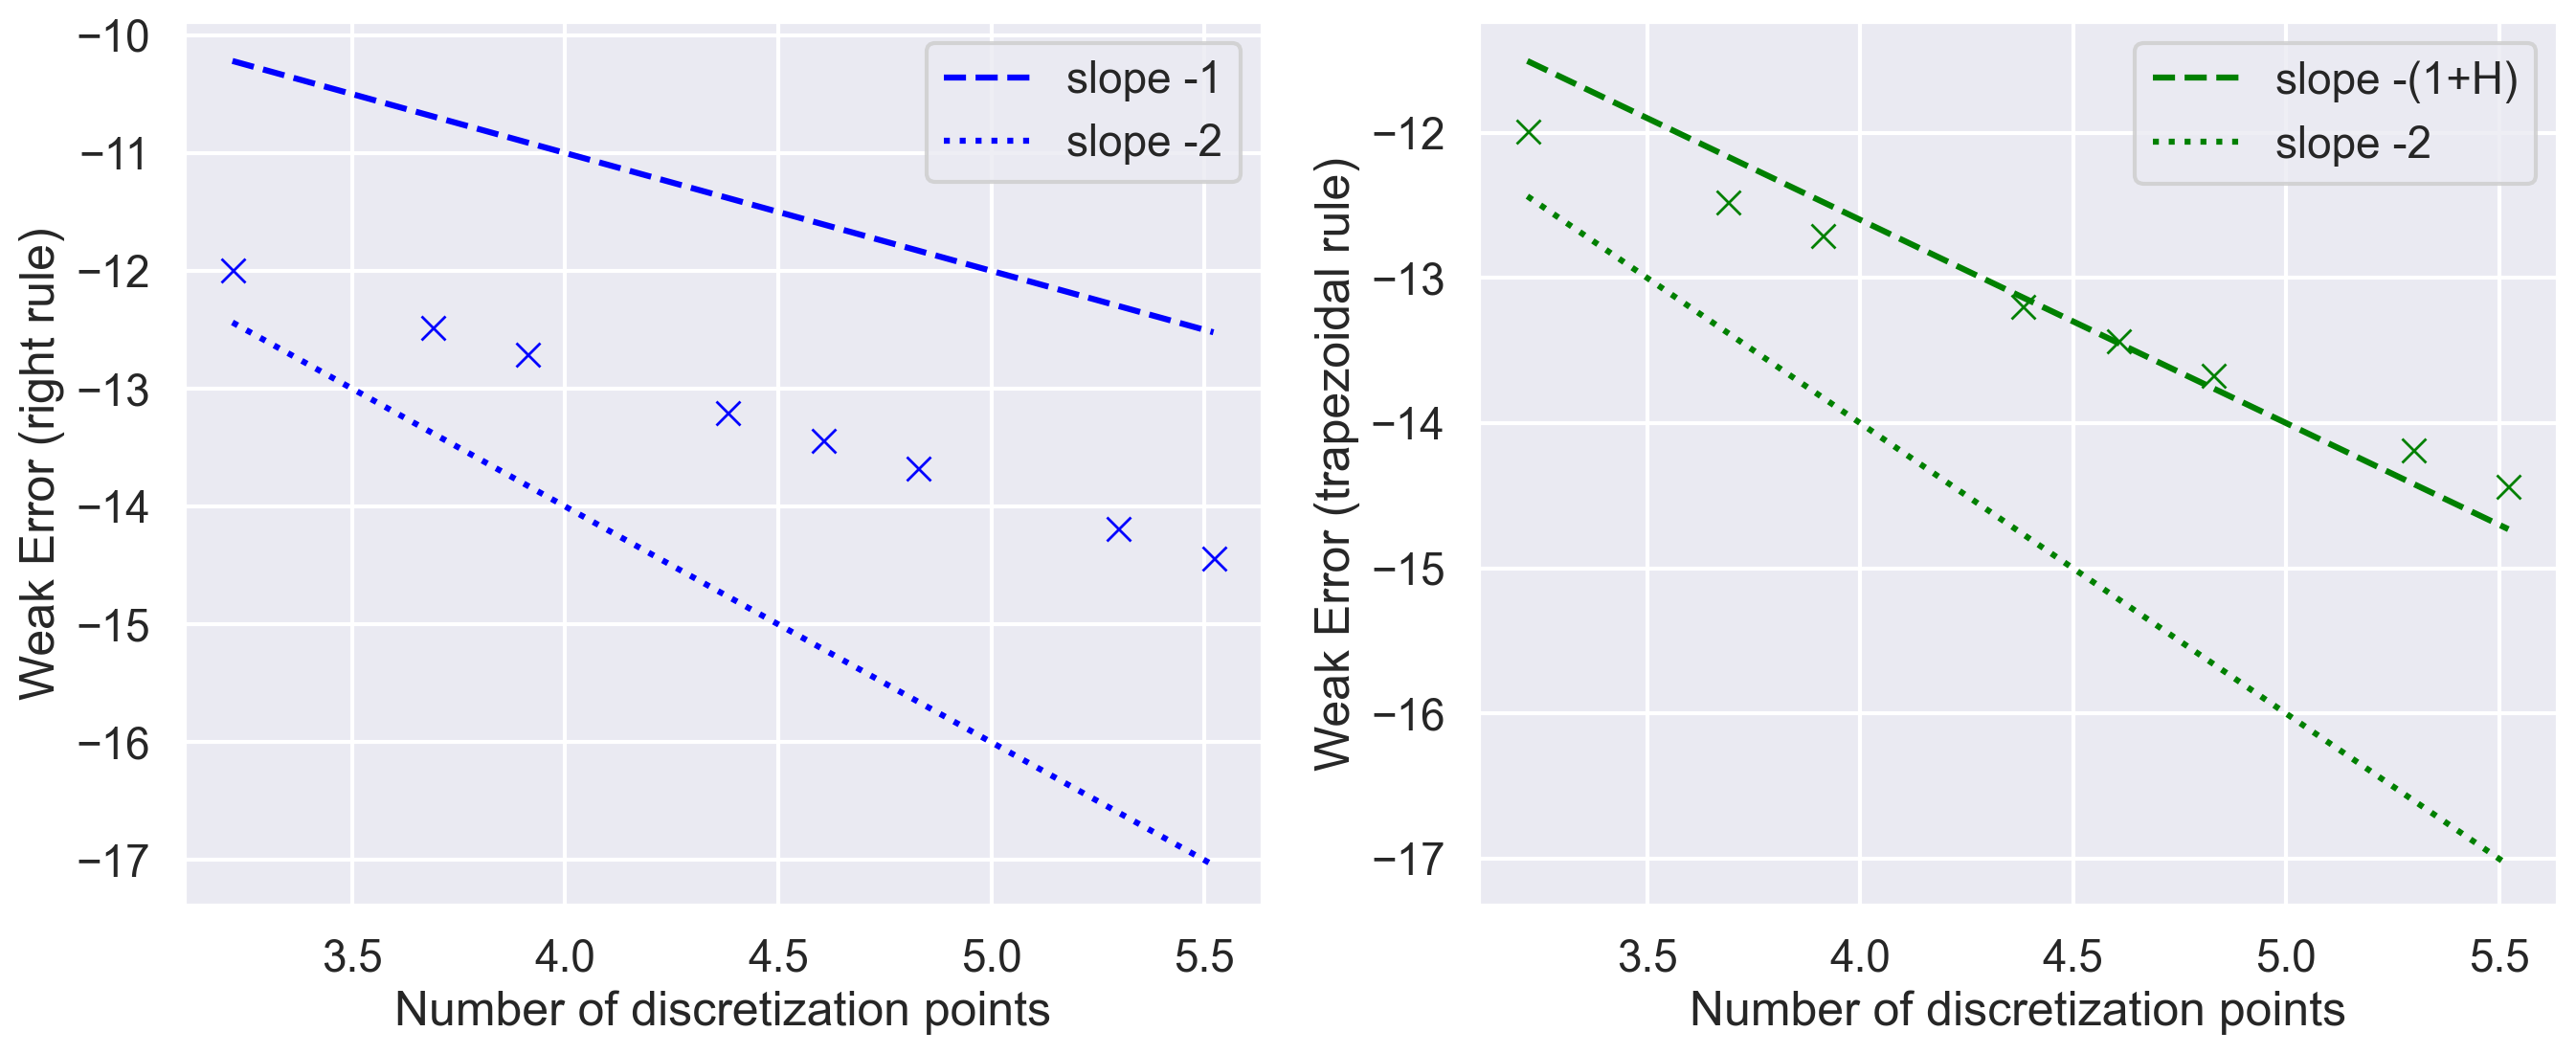

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(weak_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    -np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[0],
    label="slope -1",
)
ax[0].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[0],
    label="slope -2",
)
ax[0].legend()
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Weak Error (right rule)")
ax[1].plot(
    np.log(tab_n_disc),
    np.log(weak_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[1],
    label="slope -(1+H)",
)
ax[1].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[1],
    label="slope -2",
)
ax[1].legend()
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Weak Error (trapezoidal rule)")
plt.show()

# Multilevel Monte Carlo

We price an ATM VIX call option with a standard Monte Carlo method and a
multilevel Monte Carlo method. The payoff is given by
$$
    \varphi(x) = (x - F)^+
$$

where $F$ is the VIX futures price.

In [17]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 0.3,
}

rbergomi = RoughBergomi(**params)

In [18]:
T = 0.5
delta = rbergomi.delta_vix
n_mse = 10**3

In [19]:
n_disc_ref = 500
n_mc_ref = 5 * 10**5

In [20]:
vix_atm_call, vix_fut = rbergomi.price_vix(
    T=T,
    n_mc=n_mc_ref,
    n_disc=n_disc_ref,
    seed=SEED,
    rule="trap",
    control_variate=True,
    return_opt="both",
)

In [22]:
print(f"VIX ATM call price: {vix_atm_call[0]}")
print(f"VIX futures price: {vix_fut}")

VIX ATM call price: 0.0085379173118552
VIX futures price: 0.23402281155797855


In [ ]:
# Monte Carlo
n_eps = 5
tab_eps = np.linspace(3 * 10 ** (-2), 10 * 10 ** (-2), n_eps)

tmp_mc = [
    [
        rbergomi.compute_mse_atm_price(
            T=T,
            n_mse=n_mse,
            true_price=vix_atm_call[0],
            true_fut=float(vix_fut),
            eps=tab_eps[i],
            opt="mc",
            rule=rule,
            seed=SEED,
        )
        for i in range(len(tab_eps))
    ]
    for rule in ["right", "trap"]
]

tmp_mc = np.asarray(tmp_mc)
mse_right_mc, mse_trap_mc = tmp_mc[:, :, 0]
cost_right_mc, cost_trap_mc = tmp_mc[:, :, 1]

n_mc_eps: 1112
n_disc_eps: 34


100%|██████████| 1000/1000 [00:02<00:00, 393.43it/s]


n_mc_eps: 444
n_disc_eps: 22


100%|██████████| 1000/1000 [00:00<00:00, 1015.30it/s]


n_mc_eps: 237
n_disc_eps: 16


100%|██████████| 1000/1000 [00:00<00:00, 1875.92it/s]


n_mc_eps: 147
n_disc_eps: 13


100%|██████████| 1000/1000 [00:00<00:00, 2421.82it/s]


n_mc_eps: 100
n_disc_eps: 10


100%|██████████| 1000/1000 [00:00<00:00, 3404.28it/s]


n_mc_eps: 1112
n_disc_eps: 34


100%|██████████| 1000/1000 [00:02<00:00, 367.33it/s]


n_mc_eps: 444
n_disc_eps: 22


100%|██████████| 1000/1000 [00:01<00:00, 853.08it/s]


n_mc_eps: 237
n_disc_eps: 16


100%|██████████| 1000/1000 [00:00<00:00, 1743.88it/s]


n_mc_eps: 147
n_disc_eps: 13


100%|██████████| 1000/1000 [00:00<00:00, 2400.92it/s]


n_mc_eps: 100
n_disc_eps: 10


100%|██████████| 1000/1000 [00:00<00:00, 3340.25it/s]


In [ ]:
# Multilevel Monte Carlo
n_disc_mlmc_0 = 6
n_eps = 5
tab_eps = np.linspace(4 * 10 ** (-4), 10 * 10 ** (-4), n_eps)[::-1]

mlmc = [
    [
        rbergomi.compute_mse_atm_price(
            T=T,
            n_mse=n_mse,
            true_price=vix_atm_call[0],
            true_fut=float(vix_fut),
            eps=tab_eps[i],
            opt="mlmc",
            rule=rule,
            seed=SEED,
            n_disc_mlmc_0=n_disc_mlmc_0,
        )
        for i in range(len(tab_eps))
    ]
    for rule in ["right", "trap"]
]

mlmc = np.asarray(mlmc)
mse_right_mlmc, mse_trap_mlmc = mlmc[:, :, 0]
cost_right_mlmc, cost_trap_mlmc = mlmc[:, :, 1]

n_mc_eps: [192  48  12]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 883.63it/s]


n_mc_eps: [265  66  16]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 873.26it/s]


n_mc_eps: [390  97  24]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:02<00:00, 497.14it/s]


n_mc_eps: [842 210  52  13]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 317.72it/s]


n_mc_eps: [1592  398   99   24]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 267.63it/s]


n_mc_eps: [192  44  10]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 840.87it/s]


n_mc_eps: [265  61  14]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 731.67it/s]


n_mc_eps: [390  90  21]
n_disc_eps: [ 6 12 24]


100%|██████████| 1000/1000 [00:01<00:00, 819.12it/s]


n_mc_eps: [842 196  45  10]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 332.66it/s]


n_mc_eps: [1592  371   86   20]
n_disc_eps: [ 6 12 24 48]


100%|██████████| 1000/1000 [00:03<00:00, 273.31it/s]


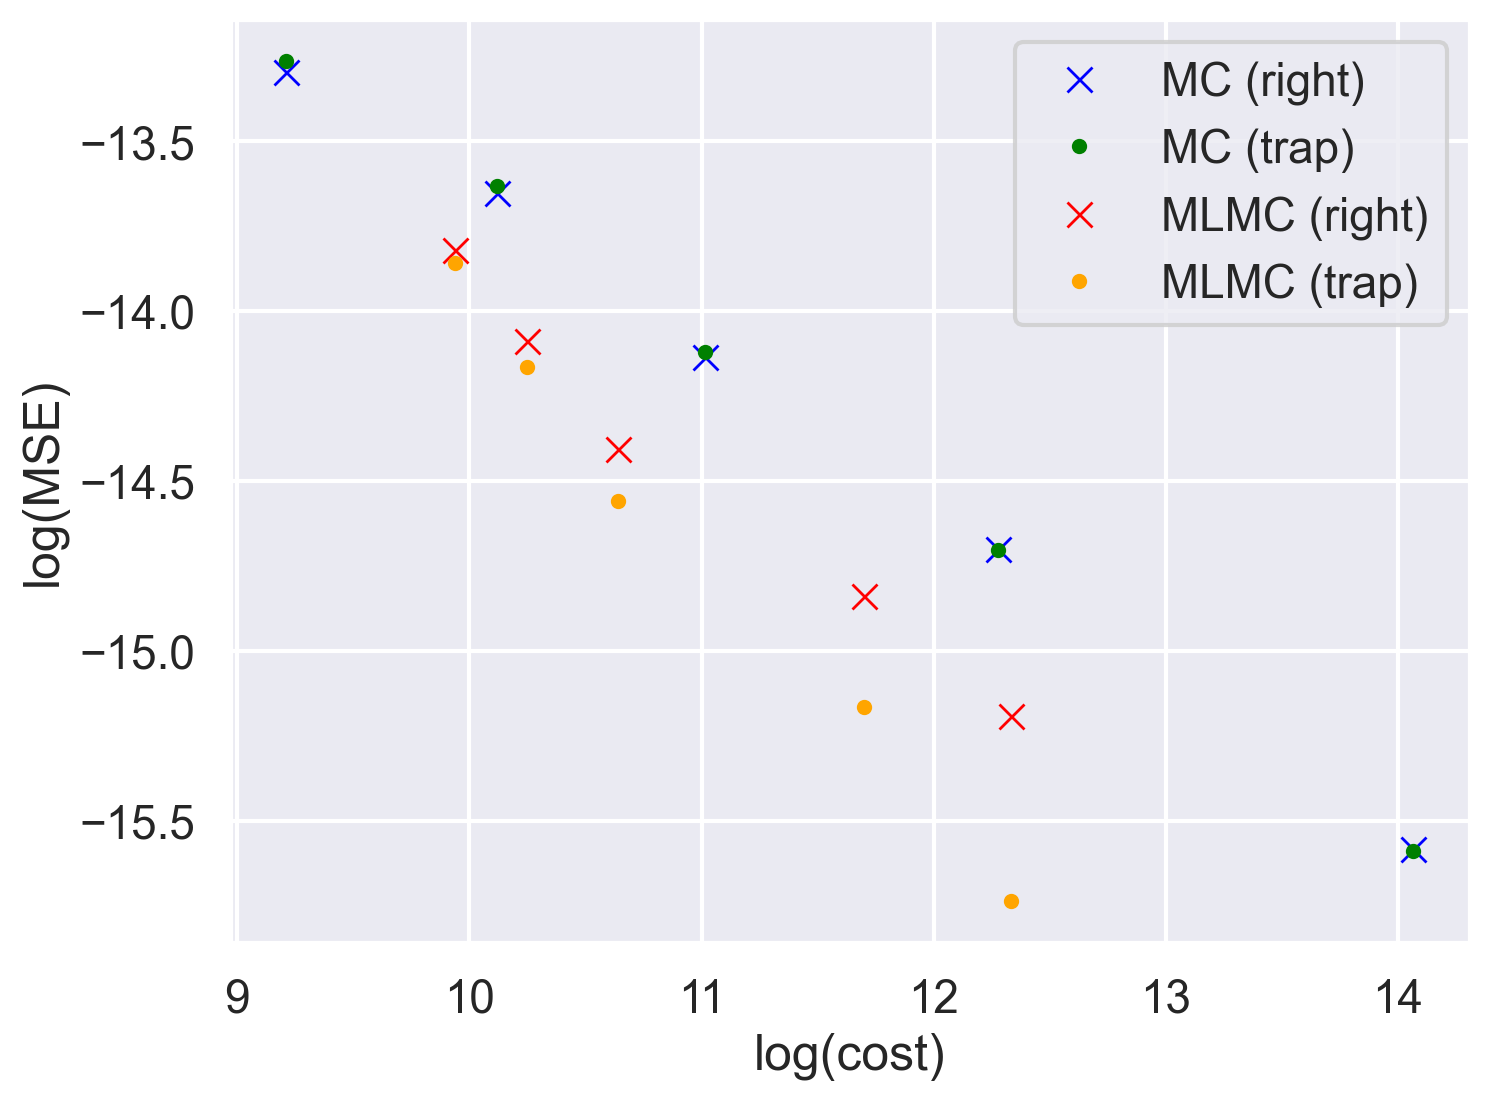

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(
    np.log(cost_right_mc),
    np.log(mse_right_mc),
    "x",
    color=COLORS[0],
    label="MC (right)",
)
ax.plot(
    np.log(cost_right_mc),
    np.log(mse_trap_mc),
    ".",
    color=COLORS[1],
    label="MC (trap)",
)
ax.plot(
    np.log(cost_right_mlmc),
    np.log(mse_right_mlmc),
    "x",
    color=COLORS[2],
    label="MLMC (right)",
)
ax.plot(
    np.log(cost_right_mlmc),
    np.log(mse_trap_mlmc),
    ".",
    color=COLORS[3],
    label="MLMC (trap)",
)
ax.set_xlabel("log(cost)")
ax.set_ylabel("log(MSE)")
ax.legend()
plt.show()

In [54]:
print("Linear regression")
alpha, beta = linear_regression(np.log(cost_right_mc), np.log(mse_right_mc))
print(f"  MC (right): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(np.log(cost_right_mc), np.log(mse_trap_mc))
print(f"  MC (trap): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(np.log(cost_right_mlmc), np.log(mse_right_mlmc))
print(f"  MLMC (right): alpha = {alpha:.3f}, beta = {beta:.3f}")
alpha, beta = linear_regression(np.log(cost_right_mlmc), np.log(mse_trap_mlmc))
print(f"  MLMC (trap): alpha = {alpha:.3f}, beta = {beta:.3f}")

Linear regression
  MC (right): alpha = -8.891, beta = -0.475
  MC (trap): alpha = -8.787, beta = -0.483
  MLMC (right): alpha = -8.504, beta = -0.544
  MLMC (trap): alpha = -6.487, beta = -0.748
